In [1]:
import numpy as np
from sklearn.decomposition import PCA
import cv2
import glob
import matplotlib.pyplot as plt
import copy
import mnist_reader as mnist
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.metrics import accuracy_score as ACC
from tqdm.notebook import tqdm

# load data

In [12]:
DATA_SET_PATH = "mnist/"
train_imgs , train_labels = mnist.load_mnist(DATA_SET_PATH , kind = 'train')
test_imgs , test_labels = mnist.load_mnist(DATA_SET_PATH , kind = 't10k')

image path mnist/train-images-idx3-ubyte.gz
image path mnist/t10k-images-idx3-ubyte.gz


In [13]:
data = np.concatenate((train_imgs , test_imgs) , axis = 0)

# standard form
data = data.T
train_imgs = train_imgs.T
test_imgs = test_imgs.T

# PCA

In [26]:
class PCA():
    def __init__(self , th = 10**1 , whiten = False):
        self.th = th
        self.whiten = whiten
        
    def fit(self , X):
        #mean of data
        self.m = np.atleast_2d(np.mean(X , axis = 1)).T
        
        #scatter matrix
        self.S = (X.shape[1]-1) * np.cov(X)
        
        #eigen values and eigen vectors
        self.w , self.V = np.linalg.eig(self.S)
        self.V = np.real(self.V)
        self.w = np.real(self.w)
        
        #condition number
        self.cn = np.max(np.abs(self.w)) / np.abs(self.w)
        
        #mask
        self.mask = self.cn < self.th
        
        
        # D matrix for whitening
        if self.whiten is False :
            self.D = np.eye(X.shape[0])
        else :
            self.D = np.diag(np.square(1/self.w[self.mask]))
            
        # transform matrix
        self.T = np.matmul(self.D , self.V[: , self.mask].T)
        
        # init some attributes
        self.n_features_ = sum(self.mask)
        self.features_ = X.shape[0]
            
    def transform(self , X):
        return np.matmul(self.T , (X - self.m))

In [15]:
pca = PCA(whiten=True)
pca.fit(data)
np.min(pca.w)

109.37509654080506

so there is no eigen value equal to 0 for this data

In [49]:
class LDA():
    def __init__(self , th  =10**10):
        self.th = th
    
    def fit(self , X , y):
        '''
            it is assumed that pca is applied to X befor appling LDA
        '''
        self.classes = np.unique(y)
        self.features = []
        
        #seperate features according to their  class label
        for cls in self.classes:
            maski = (y == cls)
            self.features.append(X[: , maski])
            
        # init data size for each class
        self.Q = np.zeros(self.classes.shape)
        for i , cls in enumerate(self.classes):
            self.Q[i] = self.features[i].shape[1]
            
        #init global mean vector
        self.mu = np.mean(X , axis=1)
            
        # init data means per class
        self.M = np.zeros((X.shape[0] , len(self.classes)))
        for i , cls in enumerate(self.classes):
            self.M[: , i] = np.mean(self.features[i] , axis=1)
        
        # init within scatte matrics
        self.W = np.zeros((X.shape[0] , X.shape[0]))
        for i , cls in enumerate(self.classes) :
            self.W += self.Q[i] * np.cov(self.features[i])
            
        #init between scatter matrix
        self.B = np.zeros((X.shape[0] , X.shape[0]))
        for i , cls in enumerate(self.classes):
            ti = self.M[: , i] - self.mu
            ti = np.atleast_2d(ti).T
            self.B += self.Q[i] * np.matmul(ti , ti.T)
            
        # init seprability matrix
        self.J = np.matmul(np.linalg.inv(self.W) , self.B)
        
        # init seprability measure
        self.j = np.trace(self.J)
        
        # find eigen values and eigen vectors
        self.w , self.V = np.linalg.eig(self.J)
        self.w = np.real(self.w)
        self.V = np.real(self.V)
        
        #condition number
        self.cn = np.max(np.abs(self.w)) / np.abs(self.w)
        
        #mask
        self.mask = self.cn < self.th
        
        # transform matrix
        self.T = self.V[: , self.mask].T
        
        # init number of mandetory components
        self.n_components_ = np.sum(self.mask)
        
    def transform(self , X):
        return np.matmul(self.T , X)
        

In [50]:
lda = LDA()
lda.fit(train_imgs , train_labels)

seprebility measure wont resuce even when darmatic dim reduction is applied

## A) eigen values in decending order

In [51]:
w = sorted(lda.w)
w[::-1]

[14.784484029841082,
 7.014625736682297,
 3.179350552384591,
 2.5527460745317643,
 2.0737606143884126,
 1.4420689424296096,
 1.3864625060599838,
 0.5525511368454639,
 0.3809643936667816,
 6.699304600590368e-14,
 6.488473984215198e-14,
 6.15584133290605e-14,
 5.536696557223821e-14,
 4.966450923119883e-14,
 4.966450923119883e-14,
 4.608007161411875e-14,
 4.608007161411875e-14,
 4.239336050715664e-14,
 4.0897668558885344e-14,
 4.0897668558885344e-14,
 3.9431650664105906e-14,
 3.9431650664105906e-14,
 3.8822597032038473e-14,
 3.8822597032038473e-14,
 3.7185597483338896e-14,
 3.696844762665348e-14,
 3.696844762665348e-14,
 3.489291087299511e-14,
 3.489291087299511e-14,
 3.440433164376838e-14,
 3.440433164376838e-14,
 3.2047851691854e-14,
 3.2047851691854e-14,
 3.07201078793155e-14,
 3.07201078793155e-14,
 3.068207302320656e-14,
 3.068207302320656e-14,
 2.928755502626114e-14,
 2.928755502626114e-14,
 2.878902141754603e-14,
 2.8525656635160236e-14,
 2.8525656635160236e-14,
 2.6734408014079418

## B) seprability vs n_components

In [52]:
sep = np.zeros((len(w),))
for i in range(len(w)):
    sep[i] = np.sum(w[i:])

Text(0, 0.5, 'sep. measure')

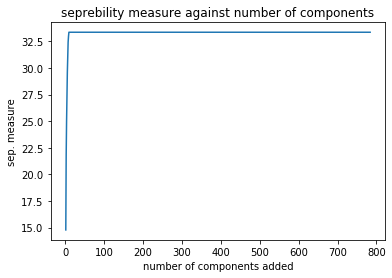

In [53]:
plt.plot([i for i in range(len(w) , 0 , -1)] , sep)
plt.title("seprebility measure against number of components")
plt.xlabel("number of components added")
plt.ylabel("sep. measure")

In [54]:
sep

array([33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36701399,
       33.36701399, 33.36701399, 33.36701399, 33.36701399, 33.36

##  number of necesarry components are 9 = c-1

In [55]:
lda.n_components_

9

## C : naive bayes with lda

In [58]:
train_red = lda.transform(train_imgs)
test_red  = lda.transform(test_imgs)

In [61]:
clf = NB()
clf.fit(train_red.T , train_labels)
pred = clf.predict(test_red.T)
ACC(pred , test_labels)

0.8123333333333334

## naive bayes without lda

In [63]:
clf = NB()
clf.fit(train_imgs.T , train_labels)
pred = clf.predict(test_imgs.T)
ACC(pred , test_labels)

0.5666666666666667